In [1]:
import ratinabox
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from ratinabox.Neurons import *
import numpy as np
import pandas as pd
from tqdm import tqdm
import math

In [ ]:
def sr_update(firing_rates, next_firing_rates, M, alpha=0.002, gamma=0.995):  
    """The sr learning rule                                                    
    Args:
        firing_rates (vector): current firing rate of basis features 
        next_firing_rates (vector): firing rate of basis features at the next time step]
        M (matrix): the SR matrix
        alpha (float): the learning rate takes values in (0,1)
        gamma (float): the discount factor takes values in (0,1)
    Returns:
        updated_M: the updated successor matrix
    """    
    delta = np.outer(firing_rates.T + gamma * (M @ next_firing_rates.T) - (M @ firing_rates.T), firing_rates)
    M += alpha * delta 
    return M, delta 

In [ ]:
def get_sander_field_widths(Env,place_field_centres):
    """Get the place field widths for the Sander et al. (2019) experiment
    Args:
        Env (object): the environment object
        place_field_centres (vector): the place field centres
    Returns:
        place_field_widths: the place field widths
    """
    G = 0.74        #we use 0.74 for biologically plausible basis features, 0 for uniform gaussian basis features (gain in basis feature width moving away from wall)
    H = 1 
    W = 0.053       #we use 0.053 for biologically plausible basis features, 0.06 for uniform gaussian basis features
    
    wall_diffs = np.squeeze(np.diff(Env.walls,axis=1))
    NS_WALLS = wall_diffs[:,0] == 0
    EW_WALLS = wall_diffs[:,1] == 0
    place_field_widths = np.zeros((len(place_field_centres),2))
    for i in range(len(place_field_centres)):
        dist_from_centre_to_walls = np.squeeze(np.linalg.norm(shortest_vectors_from_points_to_lines(place_field_centres[i], Env.walls),axis=-1))
        ns_wall_dist = np.min(dist_from_centre_to_walls[NS_WALLS])
        ew_wall_dist = np.min(dist_from_centre_to_walls[EW_WALLS])
        place_field_widths[i,0] = G*(1/H - H/(H**2 + ns_wall_dist**2)) + W
        place_field_widths[i,1] = G*(1/H - H/(H**2 + ew_wall_dist**2)) + W
    return place_field_widths

In [ ]:
# Import longest rodent trajectory or random walk path
train_traj=pd.read_csv('Laurenz_20_2.csv') 
train_traj=train_traj.to_numpy()

xs = [item[0] for item in train_traj]
ys = [item[1] for item in train_traj]

coords_rescaled=[]
for m in tqdm(range(0,len(xs))):
  if math.isnan(xs[m])==False:
    if math.isnan(xs[m])==False:
      coords_rescaled.append([(xs[m])/1040,(ys[m])/1040])       #reshape trajectory to a box the same size and what is reported in that study's paper
                                                          
xs = [item[0] for item in coords_rescaled]
ys = [item[1] for item in coords_rescaled]

coords_rescaled = coords_rescaled[::2]                          #downsample trajectory to be 10-12 Hz (::2 for Sun and Muessig data, ::5 for Lever)

xs = [item[0] for item in coords_rescaled]
ys = [item[1] for item in coords_rescaled]

times_=np.arange(0,len(coords_rescaled),1).tolist()

len(coords_rescaled)

100%|█████████████████████████████████| 29999/29999 [00:00<00:00, 900924.56it/s]


14828

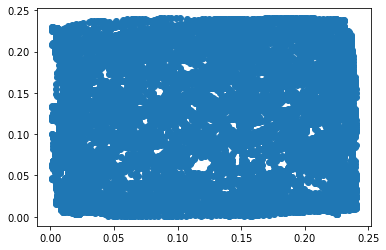

In [ ]:
# View trajectory
plt.scatter([item[0] for item in coords_rescaled],[item[1] for item in coords_rescaled])

In [ ]:
# Create RatInABox environment of the same size as that reported for the chosen study
height = 25                                     
length = 25
dt = 1 

Env = Environment( params = {'aspect':(length/105)/(height/105), 
               'scale':(height/100), 
              'dimensionality':'2D'});
Ag = Agent(Env,
            params = {
                "speed_mean": 0.9,    
                "thigmotaxis": 0.9})

N_CELLS = 400
TOTAL_TIME = len(coords_rescaled)

x_centres = np.random.uniform(low=0.01, high=(length/100)-0.01 , size=(N_CELLS,))
y_centres = np.random.uniform(low=0.01, high=(height/100)-0.1, size=(N_CELLS,))

place_field_centres = np.vstack((x_centres,y_centres)).T

You are trying to plot a different number of neurons 400 than the number of axes provided 100. Some might be missed. Either change this with the chosen_neurons argument or pass in a list of axes to plot on


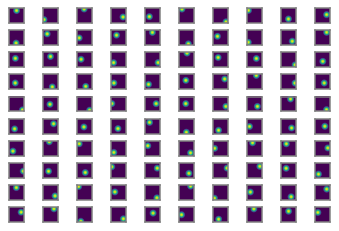

In [ ]:
#Generate a population of place cell basis features
place_field_widths = get_sander_field_widths(Env,place_field_centres)

PCs = PlaceCells(Ag,
                 params={'n': N_CELLS,
                         'description':'product_of_gaussians_threshold', #if creating basis features to be downloaded, use 'product_of_gaussians' without threshold
                         'widths':place_field_widths, 
                         'wall_geometry':'geodesic',
                         'place_cell_centres': place_field_centres, 
                         'max_fr':10,
                         'min_fr':0,
                         'color':'C1'})

fig, ax = plt.subplots(10, 10)
fig, ax = PCs.plot_rate_map(fig=fig, ax=ax, method='groundtruth',colorbar=False, cmap='jet')

In [ ]:
#Plot those basis features 
pc_rm = []
for i in range(0,len(rate_maps)):
  rm = rate_maps[i].reshape(length, height) 
  rm1 = rm/np.nansum(rm)
  rm1 = rm1 - np.percentile(rm1,40)
  rm1[rm1 < 0] = 0
  pc_rm.append(rm1)

def plot_cells(cells, n, m, rm, cell_type = ''):        
    fig = plt.figure()
    fig.set_figheight(20)
    fig.set_figwidth(15)
    for i in np.arange(n*m):
        ax = plt.subplot(n, m, i+1)
        ax.imshow(cells[i], cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(cell_type+str(i+1))
    plt.subplots_adjust(hspace=0.5,wspace=0.3)

plot_cells(cells=pc_rm, n=10 , m=10, rm=ra_maps)

In [ ]:
#Save ratemaps of basis features (unthresholded)
rate_maps = PCs.get_state(evaluate_at="all")
rate_maps.shape

for i in range(0,len(rate_maps)):
  rm = rate_maps[i].reshape(25,25) 
  rm1 = rm/np.nansum(rm)
  rm1 = rm1 - np.percentile(rm1,40)
  rm1[rm1 < 0] = 0
  #np.save('{}.npy'.format(i), rm1)

In [ ]:
# Learn successor features from basis features
dt = 1
T = len(coords_rescaled)

Ag.import_trajectory(times=times_, positions=coords_rescaled)
for i in tqdm(range(0,len(times_))):

    Ag.update(dt=dt)
    PCs.update()

Successfully imported dataset from arrays passed
Total of 14827.0 s of data available


100%|████████████████████████████████████| 14828/14828 [00:23<00:00, 620.64it/s]


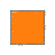

In [ ]:
# Plot trajectory to ensure fits inside RatInABox environment
fig, ax = PCs.plot_place_cell_locations()

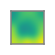

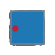

In [ ]:
# Similarly, plot agent heatmap and basis feature centres
fig, ax = Ag.plot_position_heatmap()
fig, ax = Ag.plot_trajectory()

In [ ]:
# Initialise SR matrix and update along each point of downsampled trajectory
M = np.eye(N_CELLS) 
deltas = []
for i in range(len(PCs.history['firingrate'])-3):    
    firing_rate = np.array(PCs.history['firingrate'][i])
    next_firing_rate = np.array(PCs.history['firingrate'][i+1])
    if np.linalg.norm(Ag.history['vel'][i]) > 0.0001:                           #speed filter on SR update
        M, delta = sr_update(firing_rate, next_firing_rate, M)
        deltas.append(np.mean(delta))

len(deltas)

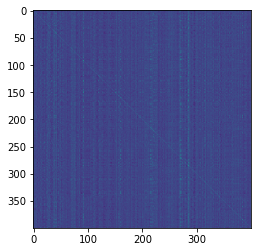

In [ ]:
# sPlot resulting SR matrix, M:
plt.imshow(M)

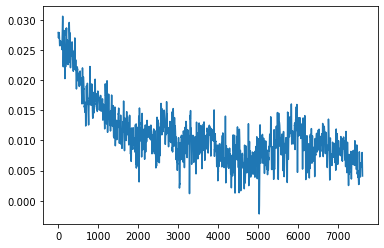

In [ ]:
# Plot the trend of deltas to ensure training has stabilised:
plt.plot(np.convolve(deltas, np.ones(6000)/6000, mode='valid'))

In [ ]:
# Calculate successor features:
ss = 1.8        #smoothing sigma 
def bin_data_for_histogramming(data, extent, dx, weights=None):
    if len(extent) == 2:  
        bins = np.arange(extent[0], extent[1] + dx, dx)
        heatmap, xedges = np.histogram(data, bins=bins, weights=weights)
        centres = (xedges[1:] + xedges[:-1]) / 2
        return (heatmap, centres)

    elif len(extent) == 4:  
        bins_x = np.arange(extent[0], extent[1] + dx, dx) 
        bins_y = np.arange(extent[2], extent[3] + dx, dx)
        heatmap, xedges, yedges = np.histogram2d(
            data[:, 0], data[:, 1], bins=[bins_x, bins_y], weights=weights
        )
        heatmap = heatmap.T[::-1, :]
        return heatmap

ra_maps=[]
for i in tqdm(range(PCs.n)):
  startid=0
  endid=len(Ag.history['t'])
  chosen_neuron=i
  ex = Ag.Environment.extent
  pos = np.array(Ag.history["pos"])[startid:endid] 

  rate_timeseries = np.array(PCs.history["firingrate"])[startid:endid].T
  rate_timeseries_ = rate_timeseries[chosen_neuron, :]
  rate_map = bin_data_for_histogramming(data=pos, extent=ex, dx=0.01, weights=rate_timeseries_) 
  ra_maps.append(rate_map)

from scipy.ndimage import gaussian_filter
class SuccessorFeature:
    def __init__(self):
        self.weights = None
        self.rate_map = None

def calculate_successor_features(basis_cells, M, rm, threshold=True):
    print('')
    print('Calculating successor features')
    smoothing_sigma = ss
    successor_features = []
    for i in tqdm(np.arange(basis_cells.n)):
        # initialise successor feature
        c = SuccessorFeature() 
        c.rate_map = np.zeros(np.shape(rm[i]))
        # get successor feature weights
        c.weights = M[i, :]
        # sum inputs
        for j in np.arange(basis_cells.n):
            c.rate_map += rm[j] * c.weights[j]
        # normalize and threshold maps
        c.rate_map = c.rate_map / np.amax(c.rate_map)
        c.rate_map = gaussian_filter(c.rate_map, smoothing_sigma)
        #if threshold == True:
            #c.rate_map = np.maximum(c.rate_map - 0.8, 0) #removed thresholding for successor_features
        successor_features.append(c)
    return successor_features

successor_features = calculate_successor_features(basis_cells=PCs,M=M,rm=ra_maps)

100%|█████████████████████████████████████████| 400/400 [02:21<00:00,  2.82it/s]



Calculating successor features


100%|████████████████████████████████████████| 400/400 [00:00<00:00, 485.02it/s]


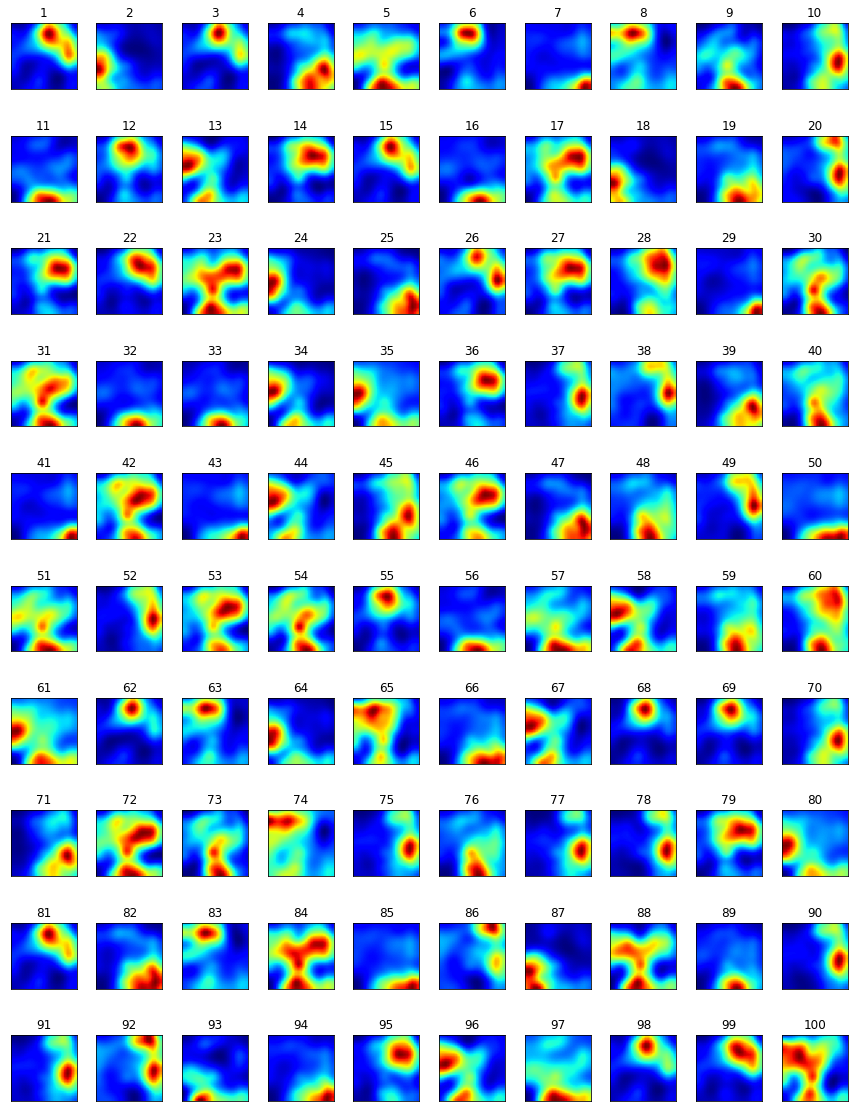

In [ ]:
# Plot resulting successor features
def plot_cells(cells, n, m, rm, cell_type = ''):         
    fig = plt.figure()
    fig.set_figheight(20)
    fig.set_figwidth(15)
    for i in np.arange(n*m):
        ax = plt.subplot(n, m, i+1)
        ax.imshow(cells[i].rate_map, cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(cell_type+str(i+1))
    plt.subplots_adjust(hspace=0.5,wspace=0.3)

plot_cells(cells=successor_features, n=10 , m=10, rm=ra_maps)

In [ ]:
# Download ratemaps from resulting successor features
for m in range(len(successor_features)):
    sf = successor_features[m].rate_map
    sf1 = sf/np.nansum(sf)
    sf1 = sf1 - np.percentile(sf1,40)
    sf1[sf1 < 0] = 0
    #np.save('SF_{}.npy'.format(m), sf1)
    

### Generating shuffled successor features 

In [ ]:
from numpy import random
from numpy.random import shuffle

def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

for i in tqdm(range(0,20)):
    M1 = shuffle_along_axis(M, axis=1)
    successor_features1 = calculate_successor_features(basis_cells=PCs,M=M1,rm=ra_maps)

    for m in range(len(successor_features1)):
        sf = successor_features1[m].rate_map
        sf1 = sf/np.nansum(sf)
        sf1 = sf1 - np.percentile(sf1,5)
        sf1[sf1 < 0] = 0
        #np.save('shuffle_{}_{}.npy'.format(i,m), sf)